In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import utils as ut

In [11]:
#Read larmip data
ds = xr.open_dataset('../data/larmip.nc')
ds

<xarray.Dataset>
Dimensions:  (rftime: 150, ism: 9, basin: 5)
Coordinates:
  * rftime   (rftime) int64 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149
  * ism      (ism) object 'CISM_NCA' 'FETI_ULB' ... 'PISM_PIK' 'SICO_ILTS'
  * basin    (basin) object 'EAIS' 'ROSS' 'AMUN' 'WEDD' 'PENS'
Data variables:
    irf      (rftime, ism, basin) float64 ...
    srf      (rftime, ism, basin) float64 ...

In [12]:
#Add dimensions

ds['time'] = np.arange(1950,2100)

ds['exp'] = ['EAIS','ROSS','AMUN','WEDD','PENS','TOTL','HALF','DOUB']
ds['ssp'] = ['126','245','585']
ds['esm'] = ['ACCESS-CM2','CAMS-CSM1-0','CAS-ESM2-0','CMCC-ESM2','CanESM5','EC-Earth3','EC-Earth3-Veg','GFDL-ESM4','INM-CM4-8','INM-CM5-0','MIROC6','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-MM']
ds

<xarray.Dataset>
Dimensions:  (rftime: 150, ism: 9, basin: 5, time: 150, exp: 8, ssp: 3, esm: 14)
Coordinates:
  * rftime   (rftime) int64 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149
  * ism      (ism) object 'CISM_NCA' 'FETI_ULB' ... 'PISM_PIK' 'SICO_ILTS'
  * basin    (basin) object 'EAIS' 'ROSS' 'AMUN' 'WEDD' 'PENS'
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
  * exp      (exp) <U4 'EAIS' 'ROSS' 'AMUN' 'WEDD' 'PENS' 'TOTL' 'HALF' 'DOUB'
  * ssp      (ssp) <U3 '126' '245' '585'
  * esm      (esm) <U13 'ACCESS-CM2' 'CAMS-CSM1-0' ... 'MRI-ESM2-0' 'NorESM2-MM'
Data variables:
    irf      (rftime, ism, basin) float64 188.6 353.5 60.47 ... 355.1 9.138
    srf      (rftime, ism, basin) float64 8.399e-06 1.527e-06 ... 2.146e-05

In [13]:
#Create variables

temp = np.zeros((len(ds.time),len(ds.esm),len(ds.ssp),len(ds.basin)))
orf  = np.zeros((len(ds.rftime),len(ds.exp),len(ds.basin)))

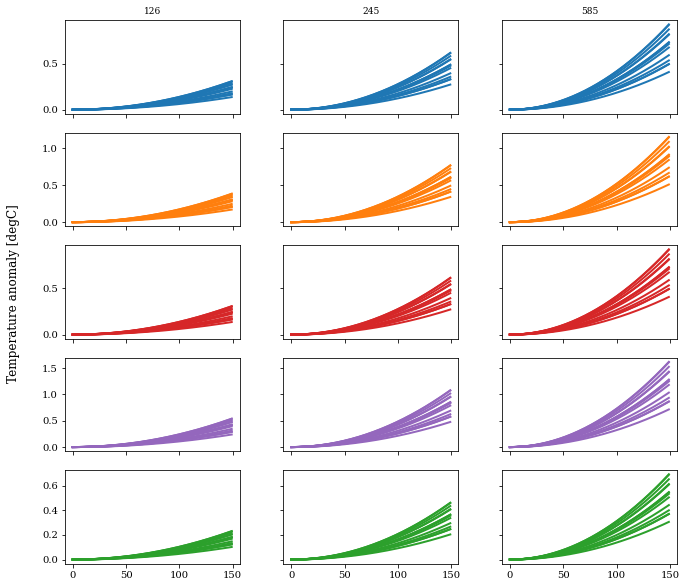

In [14]:
#Fill dummy temperature

mag = [.4,.5,.4,.7,.3]
sfac = [.5,1,1.5]
fac = np.random.uniform(low=0.6, high=1.4, size=len(ds.esm))

fig,ax = plt.subplots(len(ds.basin),len(ds.ssp),sharex=True,sharey='row',figsize=(10,10))

for s,ss in enumerate(ds.ssp.values):
    ax[0,s].set_title(ss)
    for b,bas in enumerate(ds.basin.values):
        for e,es in enumerate(ds.esm):
            temp[:,e,s,b] = fac[e]*sfac[s]*mag[b]*.00005*ds.rftime**2
            ax[b,s].plot(ds.rftime,temp[:,e,s,b],c=ut.bcol[bas],label=bas)

fig.supylabel('Temperature anomaly [degC]')
plt.show()

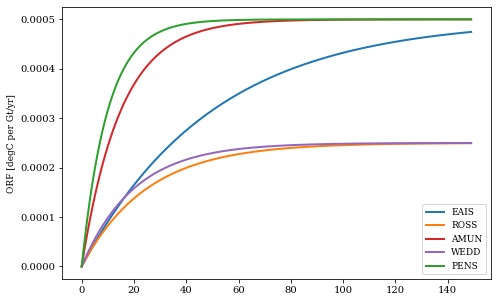

In [20]:
#Magnitude and time scale of response 

pert = 400 #Gt/yr

mag = [.2,.1,.2,.1,.2] #degC
tsc = [50,25,15,20,10] #year

for b,bas in enumerate(ds.basin):
    orf[:,b,b] = mag[b]*(1-np.exp(-ds.rftime/tsc[b]))/pert

for b,bas in enumerate(ds.basin):
    orf[:,5,b] = orf[:,b,b]

orf[:,6,:] = .5* orf[:,5,:]
orf[:,7,:] =  2* orf[:,5,:]

for b,bas in enumerate(ds.basin.values):
    plt.plot(ds.rftime,orf[:,5,b],c=ut.bcol[bas],label=bas)
plt.legend()
plt.ylabel('ORF [degC per Gt/yr]')
plt.show()

In [21]:
#Save as combined netcdf file

ds['temp'] = xr.DataArray(temp,dims=('time','esm','ssp','basin'),attrs={'unit':'degrees Celcius','long_name':'temperature anomaly from pre-industrial control'})
ds['orf']  = xr.DataArray(orf,dims=('rftime','exp','basin'),attrs={'unit':'degrees Celcius per Gt/yr','long_name':'ocean response function to increased mass loss'})

ds.to_netcdf(f'../data/dummy.nc',mode='w')
ds.close()